In [1]:
import numpy as np
import awkward as ak
import uproot
from pylab import cm
import matplotlib.pyplot as plt
import networkx as nx
import scipy.stats
import time
import random
import src.functions as fn
import src.Network as net
import hist
from hist import Hist
from mpl_toolkits.axes_grid1 import make_axes_locatable
import sys

In [2]:
#%matplotlib inline

import mplhep as hep

# Make plots look more HEP-like
plt.style.use(hep.style.ROOT)

In [3]:
#filenameBase="/eos/user/c/chpapage/TICL_samples/CloseByDoubleGamma_E100Eta1p62Delta3_CMSSW_12_4_0_upgrade2026_D86_clue3Dv4_ntuples/220701_225846/0000/"

#filename="/eos/user/c/chpapage/TICL_samples/CloseByDoubleGamma_E100Eta1p62Delta3_CMSSW_12_4_0_upgrade2026_D86_clue3Dv4_ntuples/220701_225846/0000/hgcalNtuple_*.root:ana/tracksters"
filenameFull100GeV="/eos/user/c/chpapage/TICL_samples/CloseByDoubleGamma_E100Eta1p62Delta5_CMSSW_12_4_0_upgrade2026_D86_clue3Dv4_ntuples/220701_225928/0000/ntuples.root"
filenameFull50GeV="/eos/user/c/chpapage/TICL_samples/CloseByDoubleGamma_E50Eta1p62Delta5_CMSSW_12_4_0_upgrade2026_D86_clue3Dv4_ntuples/220701_225808/0000/ntuples.root"
filenameFull25GeV="/eos/user/c/chpapage/TICL_samples/CloseByDoubleGamma_E25Eta1p62Delta5_CMSSW_12_4_0_upgrade2026_D86_clue3Dv4_ntuples/220701_225704/0000/ntuples.root"
folder="CloseByDoubleGamma_E50IncVsE25Com_Eta1p62Delta5_CMSSW_12_4_0_upgrade2026_D86_clue3Dv4"
savefigs=True
#file = uproot.open(filename)
#fileFull=uproot.concatenate(filename)
file50=uproot.open(filenameFull50GeV)
file25=uproot.open(filenameFull25GeV)
datasetName="50 GeV data inc(layerCut) vs 25 GeV data com"

In [ ]:
tracksters=file25["ana/tracksters"]
vertices_E = tracksters['vertices_energy'].array()
vertices_indexes = tracksters['vertices_indexes'].array()
vertices_x = tracksters['vertices_x'].array()
vertices_y = tracksters['vertices_y'].array()
vertices_z = tracksters['vertices_z'].array()
vertices_layers=tracksters['vertices_layer'].array()
trackster_E=tracksters['raw_energy'].array()
trackster_phi=tracksters['trackster_barycenter_phi'].array()
trackster_eta=tracksters['trackster_barycenter_eta'].array()


In [ ]:
evt=1
tr=1
TrNet=net.Network(vertices_indexes[evt,tr],vertices_x[evt,tr],vertices_y[evt,tr],
                         vertices_z[evt,tr],vertices_E[evt,tr])

In [ ]:
edges_1 = TrNet.edgeBuilderNew()
edges_1 = ak.flatten(edges_1[ak.num(edges_1) > 0].to_list())
c_pr_undir=TrNet.centralityPageRank(vertices_indexes[evt,tr],edges_1,0.85,False)

In [ ]:
i_cen_max=np.argmax(c_pr_undir)
print(i_cen_max)
print(edges_1)
print(TrNet.longestPathSource(vertices_indexes[evt,tr],edges_1,c_pr_undir))

In [ ]:
adjMatrix=TrNet.adjM(vertices_indexes[evt,tr],edges_1)

In [ ]:
len(c_pr_undir)

In [ ]:

doneList=[]
def centralityProfIter(neighborsList,doneList,n,nextList):
    sumCen=0
    for i in range(len(neighborsList)):
        #print(i)
        if(i in doneList):
            continue
        if(neighborsList[i]==0):
            continue
        else:
            sumCen+=c_pr_undir[i]
            n+=1
            doneList.append(i)
            nextList.append(adjMatrix[i,:])
            #print(nextList)
    
    return sumCen,n,doneList,nextList

def centralityProf(adjMatrix,i_cen_max):
    doneList=[]
    cenProfList=[]
    firstList=adjMatrix[i_cen_max]
    averageCen,n1,doneList,nextList=centralityProfIter(firstList,doneList,0,[])
    cenProfList.append(averageCen/n1)
    #print(firstList)
    #nextList=adjMatrix[firstList==1.]
    #print(nextList)
    j=1
    while(len(doneList)<len(firstList)):
        loopList=nextList
        nextList=[]
        #print(j)
        sumCen=0
        n=0
        for i in loopList:
            #print("loopList= {}".format(loopList))
            #print("i= {}".format(i))
            cen,n,doneList,nextList = centralityProfIter(i,doneList,n,nextList)
            sumCen+=cen
            #print("doneList= {}".format(doneList))
            #print(i==1.)
            
        if n!=0:
            cenProfList.append(sumCen/n)
        #print(loopList==1.)
        #nextList=adjMatrix[loopList==1.]
        j+=1
    return cenProfList



In [12]:
import numpy as np
import awkward as ak
import uproot
from pylab import cm
import matplotlib.pyplot as plt
import networkx as nx

class Network:
    def __init__(self, vertices_indexes, vertices_x,vertices_y,vertices_z,vertices_E):
        self.ind = vertices_indexes
        self.x = vertices_x
        self.y = vertices_y
        self.z = vertices_z
        self.E = vertices_E
        self.wtMode=0
        self.weights=np.empty(len(vertices_indexes))
        
    def setWtMode(self,wtModeVal):
        self.wtMode=wtModeVal
        
    def edgeBuilderNew(self,nEdg=1):
        # Remove that exception for the moment. Not sure if needed.
        #if len(vertices_indexes) <= nEdg:
        #    raise ValueError("Number of attempted connections 'nEdg' cannot exceed the size of the graph")
        # Create matrix of indexes
        indexes = np.stack([ak.to_numpy(self.ind)]*len(self.ind),axis=0)
        # Perform energy filtering. Keep only nodes that have greater energy that the specified node
        enMtrx = np.stack([ak.to_numpy(self.E)]*len(self.E),axis=0)
        energyMask = enMtrx > np.transpose(enMtrx)
        # Calculate euclidean distance between all nodes and apply energy mask
        distMatr = self.euclideanMatrix()
        # Sort each row and keep the indexes of the sorted arrays
        distSort = np.argsort(distMatr,axis=1)
        # Sort the euclidean distance using the indexes from previous step
        energyMaskSorted = energyMask[np.arange(energyMask.shape[0])[:,None], distSort]
        indexesSorted = indexes[np.arange(energyMask.shape[0])[:,None], distSort]
        # Some awkward magic - converts innermost array length from const to var
        indexesSorted = ak.unflatten(ak.flatten(indexesSorted), ak.num(indexesSorted))
        energyMaskSorted = ak.unflatten(ak.flatten(energyMaskSorted), ak.num(energyMaskSorted))
        # Filter nodes that have lower energy and keep nEdg nearest neighbors
        indexesSorted = indexesSorted[energyMaskSorted]
        indexesSorted = indexesSorted[:,:nEdg]
        return ak.cartesian([self.ind, indexesSorted])

    def euclideanMatrix(self):
        ver_x = ak.to_numpy(self.x)
        ver_y = ak.to_numpy(self.y)
        ver_z = ak.to_numpy(self.z)
        #subtract.outer to compute difference in all combinations
        diff_x = np.subtract.outer(ver_x,ver_x)
        diff_y = np.subtract.outer(ver_y,ver_y)
        diff_z = np.subtract.outer(ver_z,ver_z)
        euclidean_matrix = np.sqrt(diff_x**2+diff_y**2+diff_z**2)

        return euclidean_matrix

    def calcWeight(self, id1, id2,n):
        E1 = self.E[id1]
        E2 = self.E[id2]
        dx = self.x[id2]-self.x[id1]
        dy = self.y[id2]-self.y[id1]
        dz = self.z[id2]-self.z[id1]
        dist = np.sqrt(np.power(dx,2)+np.power(dy,2)+np.power(dz,2))
        """
        Default is not weighted
        Method 1: max(E1, E2)
        Method 2: |E1 - E2|
        Method 3: (d)^(-n)
        Method 4: (method 1 or 2)*(method 3)
        """
        weight = 1;
        if(self.wtMode==1):
            weight = max(E1, E2)
        elif(self.wtMode==2):
            weight = np.abs(E1-E2)
        elif(self.wtMode==3):
            weight = np.power(dist,-n)
        elif(self.wtMode==4):
            weight = np.abs(E1-E2)*np.power(dist,-n)
        elif(self.wtMode==5):
            weight = E2
        return weight
    
    def calcWeights(self,nodes,edges,n):
        for edge in edges:
            #cluster1=layerCluster(edge[0])
            #cluster2=layerCluster(edge[1])
            
            #weight=1
            id1=np.where(nodes==edge.to_list()[0])
            id2=np.where(nodes==edge.to_list()[1])
            E1 = self.E[id1]
            E2 = self.E[id2]
            dx = self.x[id2]-self.x[id1]
            dy = self.y[id2]-self.y[id1]
            dz = self.z[id2]-self.z[id1]
            dist = np.sqrt(np.power(dx,2)+np.power(dy,2)+np.power(dz,2))
            """
            Default is not weighted
            Method 1: max(E1, E2)
            Method 2: |E1 - E2|
            Method 3: (d)^(-n)
            Method 4: (method 1 or 2)*(method 3)
            """
            weight = 1;
            if(self.wtMode==1):
                weight = max(E1, E2)
            elif(self.wtMode==2):
                weight = np.abs(E1-E2)
            elif(self.wtMode==3):
                weight = np.power(dist,-n)
            elif(self.wtMode==4):
                weight = np.abs(E1-E2)*np.power(dist,-n)
            elif(self.wtMode==5):
                weight = E2
            
            self.weights[id1]=weight

    def adjM(self,nodes,edges,isDirected=False):
        adj = np.zeros((len(nodes),len(nodes)))
        for edge in edges:
            #cluster1=layerCluster(edge[0])
            #cluster2=layerCluster(edge[1])
            
            #weight=1
            idx0=np.where(nodes==edge.to_list()[0])
            idx1=np.where(nodes==edge.to_list()[1])
            weight=self.calcWeight(idx0,idx1,0)
            adj[idx0,idx1] = weight
            self.weights[idx0]=weight
            if(not isDirected):
                adj[idx1,idx0] = weight
        maxVal=adj.max()
        return adj/maxVal

    def centralityEigen(self,nodes,edges,isDirected=False,printStuff=False):
        adj=self.adjM(nodes,edges,isDirected)
        rows,columns= adj.shape
        eigvals,vecr= np.linalg.eig(adj)
        i=np.argmax(np.abs(eigvals)) 
        c_eig= vecr[:,i]
        if(c_eig[0]<0):
            c_eig *=-1
        if(printStuff):
            print(eigvals)
            print(vecr)
        c_eig_real=c_eig.real
        norm=np.linalg.norm(c_eig_real)
        return c_eig_real/norm

    def centralityKatz(self,nodes,edges,isDirected=False,printStuff=False):
        adj=self.adjM(nodes,edges,isDirected)
        rows,columns= adj.shape
        Id=np.identity(rows)
        eigvals,vecr= np.linalg.eig(adj)
        i=np.argmax(np.abs(eigvals)) 
        alpha= 0.9/eigvals[i]
        c_katz=(np.linalg.inv(Id-alpha*adj.T)-Id)@np.ones((rows)).T
        if(printStuff):
            print(eigvals)
            print(vecr)
        c_katz_real=c_katz.real
        norm=np.linalg.norm(c_katz_real)
        return c_katz_real/norm

    def centralityPageRank(self,nodes,edges,df,isDirected=False,printStuff=False):
        adj=self.adjM(nodes,edges,isDirected)
        rows,columns= adj.shape
        m_ones=np.ones((rows,columns))
        m_pr=df*adj+(1-df)*m_ones/rows
        eigvals,vecr= np.linalg.eig(m_pr)
        i=np.argmax(np.abs(eigvals)) 
        c_pr= vecr[:,i]
        if(c_pr[0]<0):
            c_pr *=-1
        if(printStuff):
            print(eigvals)
            print(vecr)
        c_pr_real=c_pr.real
        #norm=np.linalg.norm(c_pr_real)
        return c_pr_real/sum(c_pr_real)

    def nXCentralityEigen(self,nodes,edges,isDirected=False):
        if(isDirected):
            G=nx.DiGraph()
        else:
            G=nx.Graph()
        G.add_edges_from(ak.to_numpy(edges),weights=self.weights)
        G.add_nodes_from(ak.to_numpy(nodes),weights=self.weights)
        centr_d = nx.eigenvector_centrality_numpy(G)
        centr_np = np.array(list(centr_d.items()))
        return centr_np[centr_np[:, 0].argsort()][:,1]

    def nXCentralityKatz(self,nodes,edges,isDirected=False):
        if(isDirected):
            G=nx.DiGraph()
        else:
            G=nx.Graph()
        G.add_edges_from(ak.to_numpy(edges))
        G.add_nodes_from(ak.to_numpy(nodes))
        centr_d = nx.katz_centrality_numpy(G)
        centr_np = np.array(list(centr_d.items()))
        return centr_np[centr_np[:, 0].argsort()][:,1]

    def longestPathSource(self,nodes,edges,centralities,isDirected=False):
        """
        Finds the longest path in the network from the max
        of the stortest path algorithm.
        """
        if(isDirected):
            G=nx.DiGraph()
        else:
            G=nx.Graph()
        G.add_edges_from(ak.to_numpy(edges),weights=self.weights)
        G.add_nodes_from(ak.to_numpy(nodes),weights=self.weights)

        #Highest centrality node
        i_centralityMax=np.argmax(centralities)
        source=nodes[i_centralityMax]
        #Finds the shortest path from the highest centrality to all other nodes
        pathList=nx.shortest_path_length(G,source=source)
        #Takes the max of all paths to find the longest path
        longestShortestPath=max(pathList.values())
        return longestShortestPath

    
    def centralityProfIter(self,neighborsList,centrality):
        for i in range(len(neighborsList)):
            if(i in self.doneList):
                continue
            if(neighborsList[i]==0):
                continue
            else:
                #print(centrality)
                self.sumCen+=centrality[i]
                self.n+=1
                self.doneList.append(i)
                self.nextList.append(adjMatrix[i,:])
                #print(nextList)

    def centralityProf(self,adjMatrix,centrality):
        
        self.nextList=[]
        cenProfList=[max(centrality)]
        i_cen_max=np.argmax(centrality)
        self.doneList=[i_cen_max]
        firstList=adjMatrix[i_cen_max]
        self.sumCen=0
        self.n=0
        self.centralityProfIter(firstList,centrality)
        cenProfList.append(self.sumCen/self.n)
        #print(firstList)
        #nextList=adjMatrix[firstList==1.]
        #print(nextList)
        while(len(self.doneList)<adjMatrix.shape[0]):
            loopList=self.nextList
            self.nextList=[]
            #print(j)
            self.sumCen=0
            self.n=0
            for i in loopList:
                #print("loopList= {}".format(loopList))
                #print("i= {}".format(i))
                self.centralityProfIter(i,centrality)
                #print("doneList= {}".format(self.doneList))
                #print(i==1.)

            if self.n!=0:
                cenProfList.append(self.sumCen/self.n)
            #print(loopList==1.)
            #nextList=adjMatrix[loopList==1.]
            
        return cenProfList
    

In [4]:
filename = "../tracksters_ds_200e.root"
file_200e = uproot.open(filename)
tracksters = file_200e['tracksters']

In [5]:
vertices_indexes = tracksters['vertices_indexes'].array()
vertices_x = tracksters['vertices_x'].array()
vertices_y = tracksters['vertices_y'].array()
vertices_z = tracksters['vertices_z'].array()
vertices_E = tracksters['vertices_energy'].array()
trackster_label = tracksters['trackster_label'].array()

In [6]:
complete = trackster_label == 1
incomplete = trackster_label == 0

In [7]:
vertices_indexes_inc = vertices_indexes[incomplete]
vertices_x_inc = vertices_x[incomplete]
vertices_y_inc = vertices_y[incomplete]
vertices_z_inc = vertices_z[incomplete]
vertices_E_inc = vertices_E[incomplete]

vertices_indexes_com = vertices_indexes[complete]
vertices_x_com = vertices_x[complete]
vertices_y_com = vertices_y[complete]
vertices_z_com = vertices_z[complete]
vertices_E_com = vertices_E[complete]

In [8]:
tooSmall_inc = ak.num(vertices_indexes_inc,axis=-1) > 2
tooSmall_com = ak.num(vertices_indexes_com,axis=-1) > 2

In [9]:
vertices_indexes_inc_g = vertices_indexes_inc[tooSmall_inc]
vertices_x_inc_g = vertices_x_inc[tooSmall_inc]
vertices_y_inc_g = vertices_y_inc[tooSmall_inc]
vertices_z_inc_g = vertices_z_inc[tooSmall_inc]
vertices_E_inc_g = vertices_E_inc[tooSmall_inc]

vertices_indexes_com_g = vertices_indexes_com[tooSmall_com]
vertices_x_com_g = vertices_x_com[tooSmall_com]
vertices_y_com_g = vertices_y_com[tooSmall_com]
vertices_z_com_g = vertices_z_com[tooSmall_com]
vertices_E_com_g = vertices_E_com[tooSmall_com]

In [10]:
print(len(vertices_indexes_com_g))
print(len(vertices_indexes_inc_g))
print(len(vertices_indexes))

33799
12970
48249


In [ ]:
#evt=1
#tr=1

comCenProfArray=[]
comNVerticesList=[]
N_tr=1000
for tr in range(N_tr):
    TrNet=Network(vertices_indexes_com_g[tr],vertices_x_com_g[tr],vertices_y_com_g[tr],
                             vertices_z_com_g[tr],vertices_E_com_g[tr])
    edges_1 = TrNet.edgeBuilderNew()
    edges_1 = ak.flatten(edges_1[ak.num(edges_1) > 0].to_list())
    #c_pr_undir=TrNet.centralityPageRank(vertices_indexes_com_g[tr],edges_1,0.85,False)
    c_nx_eigen_undir=TrNet.nXCentralityEigen(vertices_indexes_com_g[tr],edges_1,False)
    #i_cen_max=np.argmax(c_pr_undir)
    adjMatrix=TrNet.adjM(vertices_indexes_com_g[tr],edges_1)

    cenProfList=TrNet.centralityProf(adjMatrix,c_nx_eigen_undir)
    comCenProfArray.append(cenProfList)
    comNVerticesList.append(len(vertices_indexes_com_g[tr]))

In [ ]:
incCenProfArray=[]
incNVerticesList=[]
N_tr=1000
for tr in range(N_tr):
    TrNet=Network(vertices_indexes_inc_g[tr],vertices_x_inc_g[tr],vertices_y_inc_g[tr],
                             vertices_z_inc_g[tr],vertices_E_inc_g[tr])
    edges_1 = TrNet.edgeBuilderNew()
    edges_1 = ak.flatten(edges_1[ak.num(edges_1) > 0].to_list())
    #c_pr_undir=TrNet.centralityPageRank(vertices_indexes_inc_g[tr],edges_1,0.85,False)
    c_nx_eigen_undir=TrNet.nXCentralityEigen(vertices_indexes_inc_g[tr],edges_1,False)
    adjMatrix=TrNet.adjM(vertices_indexes_inc_g[tr],edges_1)

    cenProfList=TrNet.centralityProf(adjMatrix,c_nx_eigen_undir)
    incCenProfArray.append(cenProfList)
    incNVerticesList.append(len(vertices_indexes_inc_g[tr]))

In [ ]:
print(sys.getsizeof(comCenProfArray))

In [ ]:


xValues=[]
#print(len(comCenProfArray))
for i in range(len(comCenProfArray)):
    xValues.append(np.arange(0,(len(comCenProfArray[i])))/(comNVerticesList[i]-1))
#print(xValues)
heatmap, xedges, yedges = np.histogram2d([x for xs in xValues for x in xs]
                                         ,[x for xs in comCenProfArray for x in xs],bins=50)

extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
fig=plt.figure(figsize=(8,6),dpi=100)
ax=plt.gca()
im=ax.imshow(heatmap.T, extent=extent, origin='lower', aspect='auto')
plt.title("Complete centrality profile",fontsize=22)
plt.xlabel("Length/(nVert-1)",fontsize=22)
plt.ylabel("Average centrality",fontsize=22)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="10%", pad=0.1)
   
plt.colorbar(im, cax=cax)
plt.show()
#plt.(np.arange(1,len(comCenProfArray[i])+1)/comNVerticesList[i],comCenProfArray[i])


In [ ]:


xValues=[]
#print(len(comCenProfArray))
for i in range(len(incCenProfArray)):
    xValues.append(np.arange(0,(len(incCenProfArray[i])))/(incNVerticesList[i]-1))
#print(xValues)
heatmap, xedges, yedges = np.histogram2d([x for xs in xValues for x in xs]
                                         ,[x for xs in incCenProfArray for x in xs],bins=50)

extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
fig=plt.figure(figsize=(8,6),dpi=100)
plt.clf()
ax=plt.gca()
im=ax.imshow(heatmap.T, extent=extent, origin='lower',aspect='auto')
plt.title("Incomplete centrality profile",fontsize=22)
plt.xlabel("Length/(nVert-1)",fontsize=22)
plt.ylabel("Average centrality",fontsize=22)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="10%", pad=0.1)
   
plt.colorbar(im, cax=cax)
plt.show()
#plt.(np.arange(1,len(comCenProfArray[i])+1)/comNVerticesList[i],comCenProfArray[i])


In [ ]:


xValues=[]
#print(len(comCenProfArray))
for i in range(len(comCenProfArray)):
    xValues.append(np.arange(0,(len(comCenProfArray[i])))/(len(comCenProfArray[i])-1))
#print(xValues)
heatmap, xedges, yedges = np.histogram2d([x for xs in xValues for x in xs]
                                         ,[x for xs in comCenProfArray for x in xs],bins=50)

extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
fig=plt.figure(figsize=(8,6),dpi=100)
plt.clf()
ax=plt.gca()
im=ax.imshow(heatmap.T, extent=extent, origin='lower',aspect='auto')
plt.title("Complete max path length normalized",fontsize=20)
plt.xlabel("Length to node/Length of longest path")
plt.ylabel("Average centrality")

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="10%", pad=0.1)
   
plt.colorbar(im, cax=cax)
plt.show()
#plt.(np.arange(1,len(comCenProfArray[i])+1)/comNVerticesList[i],comCenProfArray[i])


In [ ]:


xValues=[]
#print(len(comCenProfArray))
for i in range(len(incCenProfArray)):
    xValues.append(np.arange(0,(len(incCenProfArray[i])))/(len(incCenProfArray[i])-1))
#print(xValues)
heatmap, xedges, yedges = np.histogram2d([x for xs in xValues for x in xs]
                                         ,[x for xs in incCenProfArray for x in xs],bins=50)

extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
fig=plt.figure(figsize=(8,6),dpi=100)
plt.clf()
ax=plt.gca()
im=ax.imshow(heatmap.T, extent=extent, origin='lower',aspect='auto')
plt.title("Incomplete max path length normalized",fontsize=20)
plt.xlabel("Length to node/Length of longest path")
plt.ylabel("Average centrality")

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
   
plt.colorbar(im, cax=cax)
plt.show()
#plt.(np.arange(1,len(comCenProfArray[i])+1)/comNVerticesList[i],comCenProfArray[i])


In [ ]:


xValues=[]
#print(len(comCenProfArray))
for i in range(len(comCenProfArray)):
    xValues.append(np.arange(0,(len(comCenProfArray[i])))/(comNVerticesList[i]-1))

hCom_xy = hist.Hist(
    hist.axis.Regular(50, 0, 1.05, name="x",overflow="False"), hist.axis.Regular(50, 0, 1, name="y")
).fill(x=[x for xs in xValues for x in xs],y=[x for xs in comCenProfArray for x in xs])
hpCom = hCom_xy.profile("y")


xValues=[]
#print(len(comCenProfArray))
for i in range(len(incCenProfArray)):
    xValues.append(np.arange(0,(len(incCenProfArray[i])))/(incNVerticesList[i]-1))

hInc_xy = hist.Hist(
    hist.axis.Regular(50, 0, 1.05, name="x",overflow="False"), hist.axis.Regular(50, 0, 1, name="y")
).fill(x=[x for xs in xValues for x in xs],y=[x for xs in incCenProfArray for x in xs])
#print(h_xy)
hpInc = hInc_xy.profile("y")
fig=plt.figure(figsize=(8,6),dpi=100)
hpCom.plot(label='Complete')
hpInc.plot(label='Incomplete')
plt.title("Centrality profile",fontsize=22)
plt.xlabel("Length/(nVert-1)",fontsize=22)
plt.ylabel("Average centrality mean",fontsize=22)
plt.legend()
plt.show()

yCom, xCom = hpCom.to_numpy()
yInc, xInc = hpInc.to_numpy()
print(xCom)
print(yCom)
print(xInc)
print(yInc)
plt.scatter(xCom[:-1],yCom)
plt.scatter(xInc[:-1],yInc)
plt.show()

In [ ]:


xValues=[]
#print(len(comCenProfArray))
for i in range(len(comCenProfArray)):
    xValues.append(np.arange(0,(len(comCenProfArray[i])))/(len(comCenProfArray[i])-1))

hCom_xy = hist.Hist(
    hist.axis.Regular(50, 0, 1.05, name="x",overflow="False"), hist.axis.Regular(50, 0, 1, name="y")
).fill(x=[x for xs in xValues for x in xs],y=[x for xs in comCenProfArray for x in xs])
hpCom = hCom_xy.profile("y")


xValues=[]
#print(len(comCenProfArray))
for i in range(len(incCenProfArray)):
    xValues.append(np.arange(0,(len(incCenProfArray[i])))/(len(incCenProfArray[i])-1))

hInc_xy = hist.Hist(
    hist.axis.Regular(50, 0, 1.05, name="x",overflow="False"), hist.axis.Regular(50, 0, 1, name="y")
).fill(x=[x for xs in xValues for x in xs],y=[x for xs in incCenProfArray for x in xs])
#print(h_xy)
hpInc = hInc_xy.profile("y")
hpCom.plot()
hpInc.plot()
plt.show()

#yCom, xCom = hpCom.to_numpy()
#yInc, xInc = hpInc.to_numpy()

#plt.scatter(xCom[:-1],yCom)
#plt.scatter(xInc[:-1],yInc)
#plt.show()

In [ ]:


xValues=[]
#print(len(comCenProfArray))
for i in range(len(comCenProfArray)):
    xValues.append(np.arange(0,(len(comCenProfArray[i])))/(comNVerticesList[i]-1))
#print(xValues)
heatmap, xedges, yedges = np.histogram2d([x for xs in xValues for x in xs]
                                         ,[x for xs in comCenProfArray for x in xs],bins=50)
#print(heatmap.T)
#print(xedges)
#print(np.asarray(comCenProfArray))
#print(np.mean(np.array(comCenProfArray)))
#print(heatmap.shape[0])
#print(np.sum(heatmap.T,axis=1))
ybins=[(yedges[i]+yedges[i+1])/2 for i in range(len(yedges)-1)]
yValues=[sum(heatmap.T[i]*ybins)/max(sum(heatmap.T[i]),1) for i in range(heatmap.shape[0])]
#print(yValues)
plt.figure()
plt.scatter([(xedges[i]+xedges[i+1])/2 for i in range(len(xedges)-1)],yValues)
plt.title("Complete N vertices normalized")
plt.xlabel("Length to node/(Total number of vertices-1)")
plt.ylabel("Average centrality mean")
plt.show()
#plt.(np.arange(1,len(comCenProfArray[i])+1)/comNVerticesList[i],comCenProfArray[i])


In [ ]:


xValues=[]
#print(len(comCenProfArray))
for i in range(len(comCenProfArray)):
    xValues.append(np.arange(0,(len(comCenProfArray[i])))/(comNVerticesList[i]-1))
#print(xValues)
heatmap, xedges, yedges = np.histogram2d([x for xs in xValues for x in xs]
                                         ,[x for xs in comCenProfArray for x in xs],bins=50)
#print(heatmap.T)
#print(xedges)
#print(np.asarray(comCenProfArray))
#print(np.mean(np.array(comCenProfArray)))
#print(heatmap.shape[0])
#print(np.sum(heatmap.T,axis=1))
#yValues=[sum(heatmap.T[i]*ybins)/max(sum(heatmap.T[i]),1) for i in range(heatmap.shape[0])]
#print(yValues)
plt.figure()
plt.scatter([(xedges[i]+xedges[i+1])/2 for i in range(len(xedges)-1)],np.mean(heatmap.T,axis=1))
plt.title("Complete N vertices normalized")
plt.xlabel("Length to node/(Total number of vertices-1)")
plt.ylabel("Average centrality mean")
plt.show()
#plt.(np.arange(1,len(comCenProfArray[i])+1)/comNVerticesList[i],comCenProfArray[i])


In [ ]:
xValues=[]
#print(len(comCenProfArray))
for i in range(len(incCenProfArray)):
    xValues.append(np.arange(0,(len(incCenProfArray[i])))/(incNVerticesList[i]-1))
#print(xValues)
heatmap, xedges, yedges = np.histogram2d([x for xs in xValues for x in xs]
                                         ,[x for xs in incCenProfArray for x in xs],bins=50)
#print(heatmap.T)
#print(xedges)
ybins=[(yedges[i]+yedges[i+1])/2 for i in range(len(yedges)-1)]
yValues=[sum(heatmap.T[i]*ybins)/max(sum(heatmap.T[i]),1) for i in range(heatmap.shape[0])]
plt.figure()
plt.scatter([(xedges[i]+xedges[i+1])/2 for i in range(len(xedges)-1)],yValues)
plt.title("Incomplete N vertices normalized")
plt.xlabel("Length to node/(Total number of vertices-1)")
plt.ylabel("Average centrality mean")
plt.show()
#plt.(np.arange(1,len(comCenProfArray[i])+1)/comNVerticesList[i],comCenProfArray[i])


In [ ]:


xValues=[]
#print(len(comCenProfArray))
for i in range(len(comCenProfArray)):
    xValues.append(np.arange(1,(len(comCenProfArray[i])+1))/(comNVerticesList[i]-1))
#print(xValues)
heatmap, xedges, yedges = np.histogram2d([x for xs in xValues for x in xs]
                                         ,[x for xs in comCenProfArray for x in xs],bins=50)
#print(heatmap.T)
#print(xedges)
N=heatmap.shape[0]
yValues=np.array([heatmap.T[i]*(yedges[i]+yedges[i+1])/2 for i in range(N)])
print(np.sqrt(np.sum(yValues-np.sum(yValues,axis=1),axis=1)/N))
plt.figure()
plt.scatter([(xedges[i]+xedges[i+1])/2 for i in range(len(xedges)-1)],np.sqrt(abs(np.sum(yValues**2,axis=1)-np.sum(yValues,axis=1)**2))/50)
plt.title("Complete N vertices normalized")
plt.xlabel("Length to node/Total number of vertices-1")
plt.ylabel("Average centrality std")
plt.show()
#plt.(np.arange(1,len(comCenProfArray[i])+1)/comNVerticesList[i],comCenProfArray[i])


In [ ]:
xValues=[]
#print(len(comCenProfArray))
for i in range(len(incCenProfArray)):
    xValues.append(np.arange(1,(len(incCenProfArray[i])+1))/(incNVerticesList[i]-1))
#print(xValues)
heatmap, xedges, yedges = np.histogram2d([x for xs in xValues for x in xs]
                                         ,[x for xs in incCenProfArray for x in xs],bins=50)
#print(heatmap.T)
#print(xedges)
plt.figure()
plt.scatter([(xedges[i]+xedges[i+1])/2 for i in range(len(xedges)-1)],np.std(heatmap.T,axis=1))
plt.title("Incomplete N vertices normalized")
plt.xlabel("Length to node/(Total number of vertices-1)")
plt.ylabel("Average centrality std")
plt.show()
#plt.(np.arange(1,len(comCenProfArray[i])+1)/comNVerticesList[i],comCenProfArray[i])


In [19]:
#evt=1
#tr=1

comNodes2CenProfArray=[]
comNodes2NVerticesList=[]
N_tr=500
for tr in range(N_tr):
    TrNet=Network(vertices_indexes_com_g[tr],vertices_x_com_g[tr],vertices_y_com_g[tr],
                             vertices_z_com_g[tr],vertices_E_com_g[tr])
    edges_1 = TrNet.edgeBuilderNew(3)
    edges_1 = ak.flatten(edges_1[ak.num(edges_1) > 0].to_list())
    c_pr_undir=TrNet.centralityPageRank(vertices_indexes_com_g[tr],edges_1,0.85,True)
    #i_cen_max=np.argmax(c_pr_undir)
    adjMatrix=TrNet.adjM(vertices_indexes_com_g[tr],edges_1)

    cenProfList=TrNet.centralityProf(adjMatrix,c_pr_undir)
    comNodes2CenProfArray.append(cenProfList)
    comNodes2NVerticesList.append(len(vertices_indexes_com_g[tr]))

In [20]:
incNodes2CenProfArray=[]
incNodes2NVerticesList=[]
N_tr=500
for tr in range(N_tr):
    TrNet=Network(vertices_indexes_inc_g[tr],vertices_x_inc_g[tr],vertices_y_inc_g[tr],
                             vertices_z_inc_g[tr],vertices_E_inc_g[tr])
    edges_1 = TrNet.edgeBuilderNew(3)
    edges_1 = ak.flatten(edges_1[ak.num(edges_1) > 0].to_list())
    c_pr_undir=TrNet.centralityPageRank(vertices_indexes_inc_g[tr],edges_1,0.85,True)
    i_cen_max=np.argmax(c_pr_undir)
    adjMatrix=TrNet.adjM(vertices_indexes_inc_g[tr],edges_1)

    cenProfList=TrNet.centralityProf(adjMatrix,c_pr_undir)
    incNodes2CenProfArray.append(cenProfList)
    incNodes2NVerticesList.append(len(vertices_indexes_inc_g[tr]))

In [ ]:
for i in incNodes2CenProfArray:
    print(i)
    #for j in i:
        #if(j>0.4):

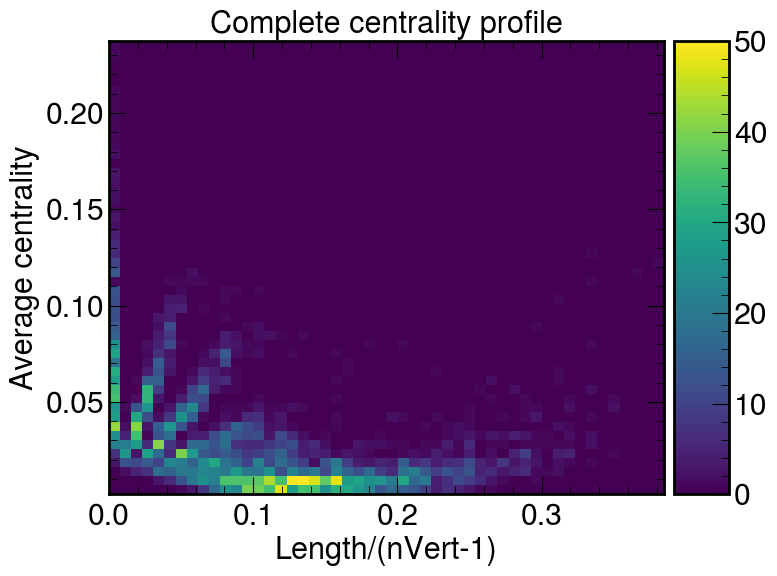

In [21]:


xValues=[]
#print(len(comCenProfArray))
for i in range(len(comNodes2CenProfArray)):
    xValues.append(np.arange(0,(len(comNodes2CenProfArray[i])))/(comNodes2NVerticesList[i]-1))
#print(xValues)
heatmap, xedges, yedges = np.histogram2d([x for xs in xValues for x in xs]
                                         ,[x for xs in comNodes2CenProfArray for x in xs],bins=50)

extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
fig=plt.figure(figsize=(8,6),dpi=100)
ax=plt.gca()
im=ax.imshow(heatmap.T, extent=extent, origin='lower', aspect='auto')
plt.title("Complete centrality profile",fontsize=22)
plt.xlabel("Length/(nVert-1)",fontsize=22)
plt.ylabel("Average centrality",fontsize=22)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="10%", pad=0.1)
   
plt.colorbar(im, cax=cax)
plt.show()
#plt.(np.arange(1,len(comCenProfArray[i])+1)/comNVerticesList[i],comCenProfArray[i])


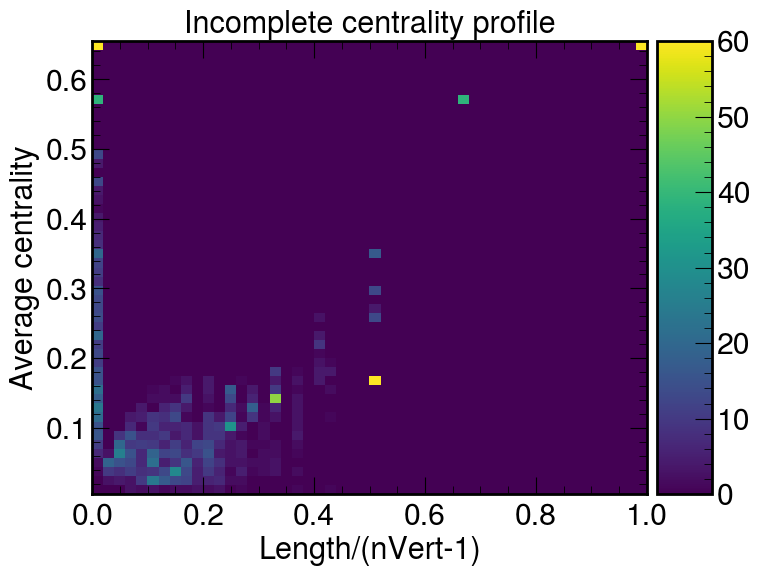

In [22]:


xValues=[]
#print(len(comCenProfArray))
for i in range(len(incNodes2CenProfArray)):
    xValues.append(np.arange(0,(len(incNodes2CenProfArray[i])))/(incNodes2NVerticesList[i]-1))
#print(xValues)
heatmap, xedges, yedges = np.histogram2d([x for xs in xValues for x in xs]
                                         ,[x for xs in incNodes2CenProfArray for x in xs],bins=50)

extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
fig=plt.figure(figsize=(8,6),dpi=100)
plt.clf()
ax=plt.gca()
im=ax.imshow(heatmap.T, extent=extent, origin='lower',aspect='auto')
plt.title("Incomplete centrality profile",fontsize=22)
plt.xlabel("Length/(nVert-1)",fontsize=22)
plt.ylabel("Average centrality",fontsize=22)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="10%", pad=0.1)
   
plt.colorbar(im, cax=cax)
plt.show()
#plt.(np.arange(1,len(comCenProfArray[i])+1)/comNVerticesList[i],comCenProfArray[i])


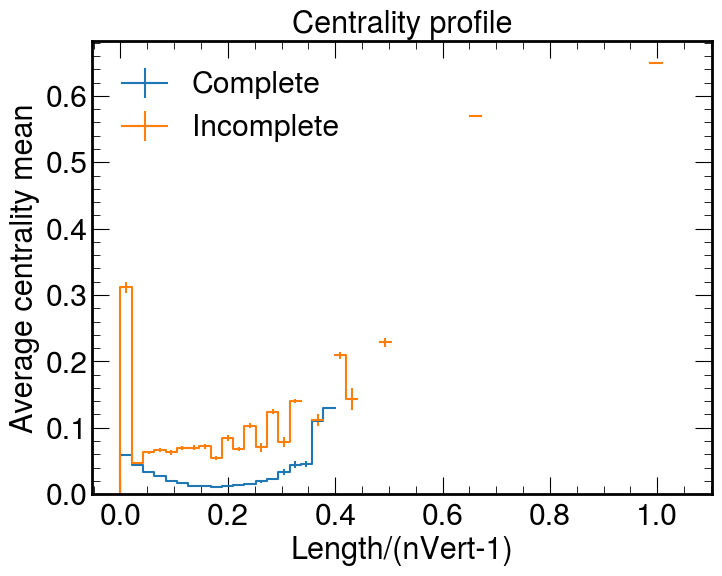

In [23]:


xValues=[]
#print(len(comCenProfArray))
for i in range(len(comNodes2CenProfArray)):
    xValues.append(np.arange(0,(len(comNodes2CenProfArray[i])))/(comNodes2NVerticesList[i]-1))

hCom_xy = hist.Hist(
    hist.axis.Regular(50, 0, 1.05, name="x",overflow="False"), hist.axis.Regular(50, 0, 1, name="y")
).fill(x=[x for xs in xValues for x in xs],y=[x for xs in comNodes2CenProfArray for x in xs])
hpCom = hCom_xy.profile("y")


xValues=[]
#print(len(comCenProfArray))
for i in range(len(incNodes2CenProfArray)):
    xValues.append(np.arange(0,(len(incNodes2CenProfArray[i])))/(incNodes2NVerticesList[i]-1))

hInc_xy = hist.Hist(
    hist.axis.Regular(50, 0, 1.05, name="x",overflow="False"), hist.axis.Regular(50, 0, 1, name="y")
).fill(x=[x for xs in xValues for x in xs],y=[x for xs in incNodes2CenProfArray for x in xs])
#print(h_xy)
hpInc = hInc_xy.profile("y")
fig=plt.figure(figsize=(8,6),dpi=100)
hpCom.plot(label='Complete')
hpInc.plot(label='Incomplete')
plt.title("Centrality profile",fontsize=22)
plt.xlabel("Length/(nVert-1)",fontsize=22)
plt.ylabel("Average centrality mean",fontsize=22)
plt.legend()
plt.show()
